# Lab 4- Model Building

In this lab, we will attempt to follow the first paper on Deep Learning in High Energy physics [P. Baldi, et al](https://arxiv.org/pdf/1402.4735.pdf). This paper demonstrates that Deep Neural Networks can learn from rad data the features that are typically used by physicists for searches for exotics particles. The authors provide the data they used for this paper. They considered two benchmark scenarios. We will focus on the SUSY benchmark. The physics behind this sample will be discussed in class.

The data is provided as a comma separated file:

In [1]:
filename="/data/afarbin/DLClass/SUSY/SUSY.csv"
# print out the first 5 lines using unix head command
!head -5  "/data/afarbin/DLClass/SUSY/SUSY.csv"

0.000000000000000000e+00,9.728614687919616699e-01,6.538545489311218262e-01,1.176224589347839355e+00,1.157156467437744141e+00,-1.739873170852661133e+00,-8.743090629577636719e-01,5.677649974822998047e-01,-1.750000417232513428e-01,8.100607395172119141e-01,-2.525521218776702881e-01,1.921887040138244629e+00,8.896374106407165527e-01,4.107718467712402344e-01,1.145620822906494141e+00,1.932632088661193848e+00,9.944640994071960449e-01,1.367815494537353516e+00,4.071449860930442810e-02
1.000000000000000000e+00,1.667973041534423828e+00,6.419061869382858276e-02,-1.225171446800231934e+00,5.061022043228149414e-01,-3.389389812946319580e-01,1.672542810440063477e+00,3.475464344024658203e+00,-1.219136357307434082e+00,1.295456290245056152e-02,3.775173664093017578e+00,1.045977115631103516e+00,5.680512785911560059e-01,4.819284379482269287e-01,0.000000000000000000e+00,4.484102725982666016e-01,2.053557634353637695e-01,1.321893453598022461e+00,3.775840103626251221e-01
1.000000000000000000e+00,4.4483992457389831

Each row represents a LHC collision event. Each column contains some observable from that event. The variable names are:

In [2]:
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]

Some of these variables represent the "raw" kinematics of the observed final state particles, while others are "features" that are derived from these raw quantities:

In [3]:
RawNames=["l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi"]
FeatureNames=[ "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]

We will use pandas to read in the file, and matplotlib to make plots. The following ensures pandas is installed and sets everything up:

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Now we can read the data into a pandas dataframe:

In [5]:
df = pd.read_csv(filename, dtype='float64', names=VarNames)

You can see the data in Jupyter by just evaluating the dataframe:

In [6]:
#df

The first column stores the "truth" label of whether an event was signal or background. Pandas makes it easy to create dataframes that store only the signal or background events:

In [7]:
df_sig=df[df.signal==1]
df_bkg=df[df.signal==0]

The following example plots the signal and background distributions of every variable. Note that we use VarNames[1:] to skip the first variable, which was the true label.

l_1_pT


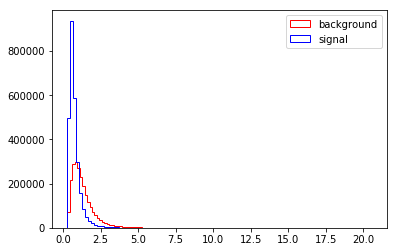

l_1_eta


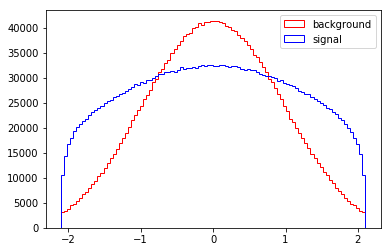

l_1_phi


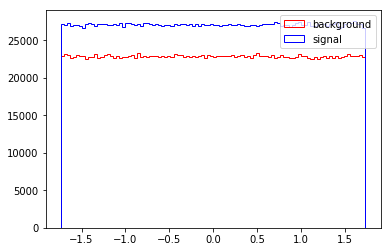

l_2_pT


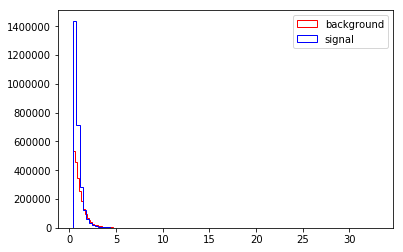

l_2_eta


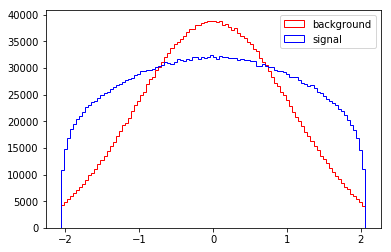

l_2_phi


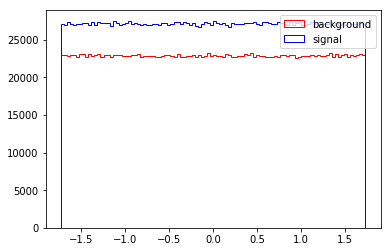

MET


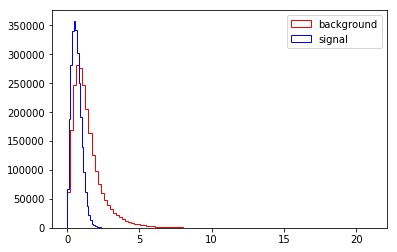

MET_phi


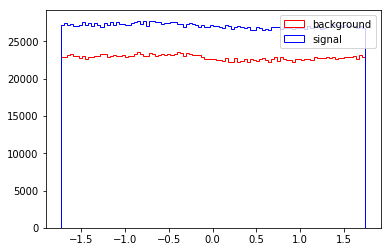

MET_rel


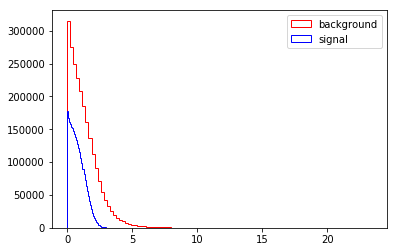

axial_MET


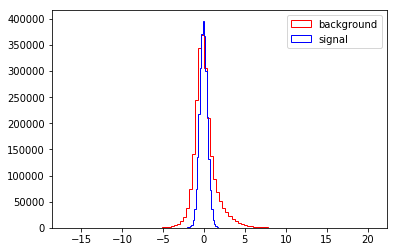

M_R


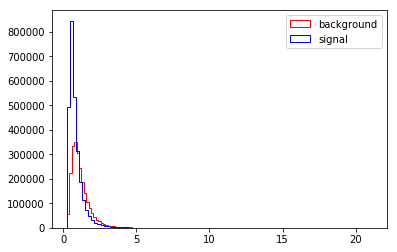

M_TR_2


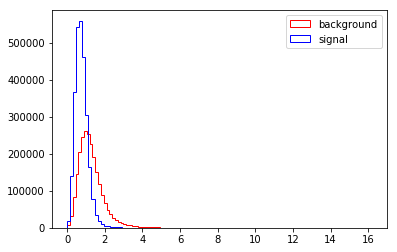

R


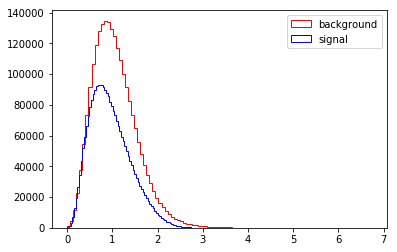

MT2


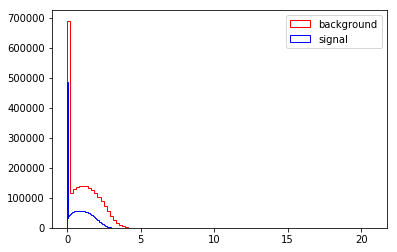

S_R


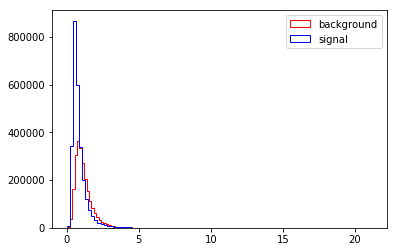

M_Delta_R


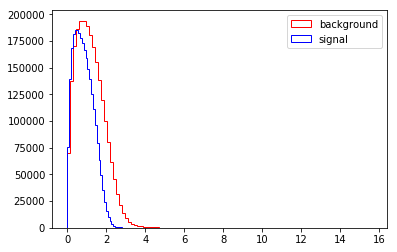

dPhi_r_b


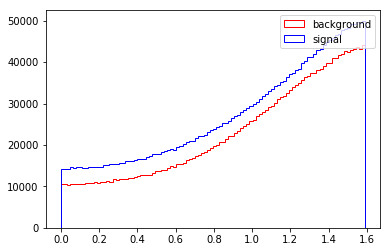

cos_theta_r1


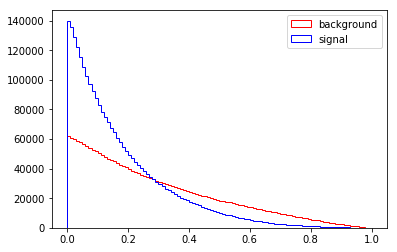

In [8]:
for var in VarNames[1:]:
    print var
    plt.figure()
    plt.hist(df_sig[var],bins=100,histtype="step", color="red",label="background",stacked=True)
    plt.hist(df_bkg[var],bins=100,histtype="step", color="blue", label="signal",stacked=True)
    plt.legend(loc='upper right')
    plt.show()

## Building a classifier with Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). The [LDA Documentation](http://scikit-learn.org/stable/modules/lda_qda.html#dimensionality-reduction-using-linear-discriminant-analysis) does as great job explaining this classifier. Here's how we instanciate the classifier: 

In [9]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

Lets separate the data into inputs (X) vs outputs (Y) and training vs testing samples:

In [10]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [11]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

We can plot the output, comparing signal and background:

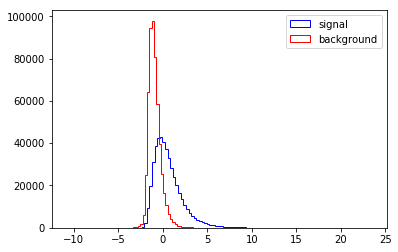

In [12]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

And we can make a ROC curve and evaluate the AUC:

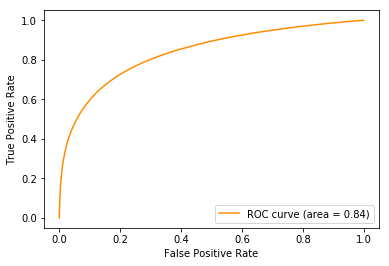

In [13]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

## Exercise 4.1

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performances on a single plot. Add cells to this notebook as needed.

In [14]:
#This cell splits up the data in just the raw inputs, X_ Raw, and just the feature inputs, X_ Feat
#The y's needn't be changed since it is the same in all cases


X_TrainRaw=Train_Sample[RawNames[:]]
X_TestRaw=Test_Sample[RawNames[:]]


X_TrainFeat = Train_Sample[FeatureNames[:]]
X_TestFeat = Test_Sample[FeatureNames[:]]

#####Troubleshooting area#####
print X_Train.shape
print X_TrainRaw.shape
print X_TrainFeat.shape
print y_Train.shape
print Test_sig[VarNames[1:]].shape

(4000000, 18)
(4000000, 6)
(4000000, 12)
(4000000,)
(458233, 18)


In [15]:
#This cell doesn't work the way I expect it to

Full = Fisher.fit(X_Train,y_Train)
Raw  = Fisher.fit(X_TrainRaw,y_Train)
Feat = Fisher.fit(X_TrainFeat,y_Train)

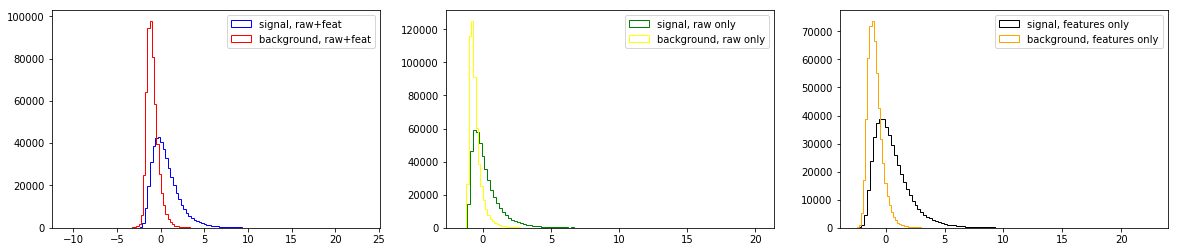

In [16]:
#This cell plots the histograms of the test input resulting from the 3 training sets

plt.figure(figsize=(20,4))

#histogram of signal and bkg from DA with full input
Fisher.fit(X_Train,y_Train)
plt.subplot(1,3,1)
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal, raw+feat",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background, raw+feat",stacked=True)
plt.legend(loc='upper right')

#histogram of signal and bkg from DA with only raw as input
plt.subplot(1,3,2)
Fisher.fit(X_TrainRaw,y_Train)
plt.hist(Raw.decision_function(Test_sig[RawNames[:]]),bins=100,histtype="step", color="green", label="signal, raw only",stacked=True)
plt.hist(Raw.decision_function(Test_bkg[RawNames[:]]),bins=100,histtype="step", color="yellow", label="background, raw only",stacked=True)
plt.legend(loc='upper right')

#histogram of signal and bkg from DA with only features as input
plt.subplot(1,3,3)
Fisher.fit(X_TrainFeat,y_Train)
plt.hist(Feat.decision_function(Test_sig[FeatureNames[:]]),bins=100,histtype="step", color="black", label="signal, features only",stacked=True)
plt.hist(Feat.decision_function(Test_bkg[FeatureNames[:]]),bins=100,histtype="step", color="orange", label="background, features only",stacked=True)
plt.legend(loc='upper right')

plt.show()

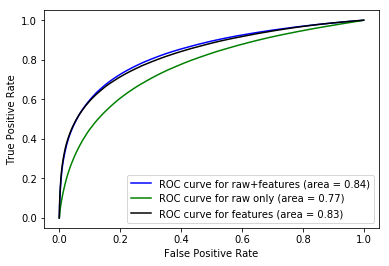

In [17]:
Fisher.fit(X_Train,y_Train)
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,color='blue',label='ROC curve for raw+features (area = %0.2f)' % roc_auc)

Fisher.fit(X_TrainRaw,y_Train)
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_TestRaw))
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,color='green',label='ROC curve for raw only (area = %0.2f)' % roc_auc)

Fisher.fit(X_TrainFeat,y_Train)
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_TestFeat))
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,color='black',label='ROC curve for features (area = %0.2f)' % roc_auc)

plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

## Exercise 4.2

Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Note that you can use the multi-layer peceptron to build a deep network, though training may be prohibitively slow, so avoid this technique. Perform the comparison in exercise 1 for each classifier. Compare your conclusions for your selected techniques to the paper.


In [18]:
from sklearn import linear_model
SGD = linear_model.SGDClassifier()
SGD.fit(X_Train,y_Train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

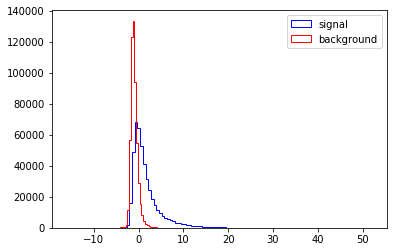

In [19]:
###model documentation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

plt.figure()
plt.hist(SGD.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(SGD.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

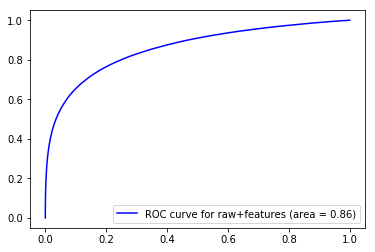

In [20]:
fpr, tpr, _ = roc_curve(y_Test, SGD.decision_function(X_Test))
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,color='blue',label='ROC curve for raw+features (area = %0.2f)' % roc_auc)
plt.legend(loc='best')
plt.show()

In [21]:
from sklearn.linear_model import PassiveAggressiveClassifier
PA = PassiveAggressiveClassifier(random_state=0)
PA.fit(X_Train,y_Train)


PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=5, n_jobs=1, random_state=0,
              shuffle=True, verbose=0, warm_start=False)

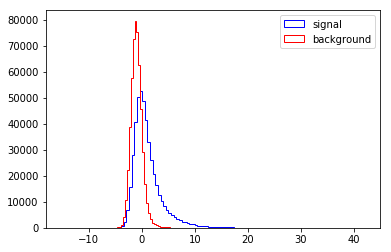

In [22]:
plt.figure()
plt.hist(PA.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(PA.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.svm import LinearSVC
LinSVC = LinearSVC(random_state=0)
LinSVC.fit(X_Train,y_Train)

In [26]:
plt.figure()
plt.hist(neigh.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(neigh.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

## Exercise 4.3

The following function calculates the significance of the observation of the signal given the number of expected Signal and Background events, using the simple formula $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$. Read through the code carefully.

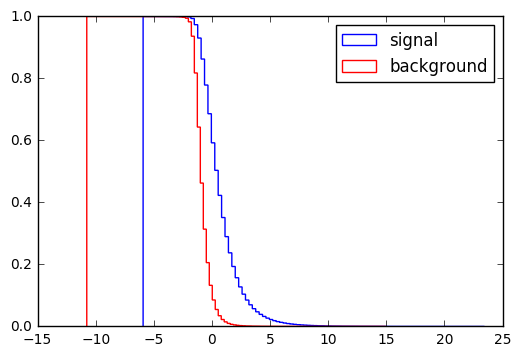

100


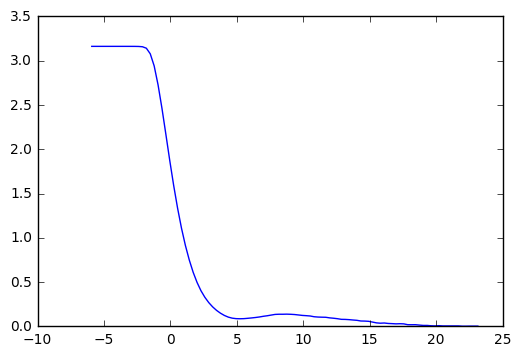

Max significance at  -5.92031800082  of 3.1622618489


(-5.9203180008157137, 3.1622618488986629, 0)

In [113]:
def PlotSignificance(N_S,N_B, N_S_min=1):
    plt.figure()
    eff_sig,bins_sig,p_sig=plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",cumulative=-1,stacked=True,normed=True)
    eff_bkg,bins_bkg,p_bkg=plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",cumulative=-1,stacked=True,normed=True)
    plt.legend(loc='upper right')
    plt.show()
    
    good_bins = np.where(eff_sig*N_S>=N_S_min)

    print len(good_bins[0])
    if len(good_bins[0])<1:
        print "Insufficient Signal."
        return 0,0,0
    
    significance=(N_S*eff_sig)/np.sqrt((N_B*eff_bkg)+(N_S*eff_sig))

    plt.figure()
    plt.plot(bins_sig[:-1],significance)
    
    max_sign=np.max(significance[good_bins])
    max_signI=np.argmax(significance[good_bins])
    
    plt.show()
    print "Max significance at ", bins_sig[max_signI], " of", max_sign
    return bins_sig[max_signI],max_sign, max_signI
    
PlotSignificance(1000000,1e11)


Answer the following questions:
   * What are we computing when making a normalized cummulative plot? 
   * Assume that the experiment produces 1 signal event for every $10^{11}$ background events. For each of your classifiers, how many signal events need to be produced to be able to make a $5\sigma$ discovery claim?
  

## Honors problems:

### Exercise 4.4

Read the paper and attempt to reproduce the results, as closely as possible, using scikit-learn. 
Try using the [multi-layer peceptron](http://scikitlearn.org/stable/modules/neural_networks_supervised.html#multi-layer-perceptron) to build a deep network. Or if you are capable, try it using [Keras Scikit-learn interface](https://keras.io/scikit-learn-api/). 
                                                